# 1. Importing libraries, helper functions and datapaths

### 1.1 Importing libraries

In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchinfo import summary

In [2]:
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
from tqdm.auto import tqdm
from typing import List, Tuple, Dict

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 1.2 Importing helper functions

In [5]:
from going_modular.engine import train_step
from going_modular.data_setup import create_dataloaders

In [6]:
def val_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device = torch.device)->Tuple[float,float]:

    #putting model on evaluation mode
    model.eval()

    #Setup test loss and test accuracy values
    val_loss, val_acc = 0,0

    #turning on inference mode (we don't need the gradient engine activated)
    with torch.inference_mode():
        #Loop through Dataloader batches
        for batch, (X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)

            #1. Forward pass
            val_pred_logits = model(X)

            #2. Calculate the loss
            loss = loss_fn(val_pred_logits,y)
            val_loss += loss.item()

            #Calculate the accuracy
            val_pred_labels = torch.argmax(val_pred_logits, axis = 1)
            val_acc += (val_pred_labels==y).sum().item()/len(val_pred_labels)

    val_loss = val_loss/len(dataloader)
    val_acc = val_acc/len(dataloader)

    return val_loss, val_acc

In [7]:
from torch.utils.tensorboard import SummaryWriter

def create_writer(experiment_name: str,
                 model_name: str,
                 extra: str = None):
    '''
    Creates a torch.utils.tensorboard.writer.SummaryWriter() instance trancking to a specific directory
    '''
    from datetime import datetime
    import os

    #get timestamp of current date in reverse order
    timestamp = datetime.now().strftime("%Y-%m-%d")

    if extra:
        log_dir = os.path.join('Publication_Phase_2_logs',timestamp,experiment_name,model_name,extra)
    else:
        log_dir = os.path.join('Publication_Phase_2_logs',timestamp,experiment_name,model_name)

    print(f"Created SummaryWriter saving to {log_dir}")
    return SummaryWriter(log_dir)

In [8]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

def train(model: torch.nn.Module,
         train_dataloader,
         val_dataloader,
         optimizer,
         writer: torch.utils.tensorboard.writer.SummaryWriter,
         loss_fn: torch.nn.Module = nn.CrossEntropyLoss,
         epochs: int = 5,
         device = torch.device,
         lr_scheduler = None)->Dict[str,List]:

    #Create dictionary of lists
    results = {"train_loss": [],
              "train_acc": [],
              "val_loss": [],
              "val_acc": []}

    #looping through training and test steps
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                          dataloader = train_dataloader,
                                          loss_fn = loss_fn,
                                          optimizer = optimizer,
                                          device = device)

        val_loss, val_acc = val_step(model = model,
                                       dataloader = val_dataloader,
                                       loss_fn = loss_fn,
                                       device = device)
        current_lr = optimizer.param_groups[0]['lr']

        #print out what's happening
        print(f'''Epoch: {epoch+1}| Train loss: {train_loss:.4f} and Train acuuracry: {train_acc:.4f} |
                  Validation loss: {val_loss:.4f} and Validation accuracy: {val_acc:.4f}|
                  LR: {current_lr}''')


        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        ###Alteration (NEW): Experiment Tracking###
        if writer:
            writer.add_scalars(main_tag = "Loss",
                              tag_scalar_dict = {"train_loss":train_loss,
                                                "val_loss":val_loss},
                              global_step=epoch)
            writer.add_scalars(main_tag = "Accuracy",
                             tag_scalar_dict = {"train_acc":train_acc,
                                               "val_acc":val_acc},
                             global_step = epoch)
            if epoch == 0:
                writer.add_graph(model = model,
                                input_to_model = torch.randn(32,3,224,224).to(device))
        else:
            pass

        #stepping the lr_scheduler
        if lr_scheduler is not None:
            lr_scheduler.step()
    #Close the writer
    writer.close()

    return results

In [9]:
def save_model(model: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler._LRScheduler = None,
               epoch: int = 0,
               initial_training_completed: bool = False,
               target_dir: str = "models",
               model_name: str = "model_checkpoint.pth"):
    """
    Saves a dictionary containing model, optimizer, scheduler states, and training metadata.

    Args:
        model: The PyTorch model to save.
        optimizer: The optimizer used during training.
        scheduler: The learning rate scheduler used during training (optional).
        epoch: The current epoch number.
        initial_training_completed: Flag indicating if initial training phase is complete.
        target_dir: Directory where the checkpoint will be saved.
        model_name: Filename for the checkpoint, should end with '.pth' or '.pt'.

    Example usage:
        save_model(model=model_0,
                   optimizer=optimizer,
                   scheduler=scheduler,
                   epoch=15,
                   initial_training_completed=True,
                   target_dir="models",
                   model_name="efficientnet_b0_initial_training.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True, exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), \
        "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save checkpoint dictionary
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'initial_training_completed': initial_training_completed,
    }

    print(f"[INFO] Saving checkpoint to: {model_save_path}")
    torch.save(obj=checkpoint, f=model_save_path)

In [10]:
import matplotlib.pyplot as plt
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]], title=None):
    '''
    Plots training curves of a results dictionary with unique markers and grid lines.
    '''
    # Get the loss and accuracy values
    loss = results["train_loss"]
    test_loss = results["val_loss"]
    accuracy = results["train_acc"]
    test_accuracy = results["val_acc"] 
    
    # Number of epochs
    epochs = range(len(loss))
    
    # Setup plot
    plt.figure(figsize=(13, 6))
    
    # Plot the loss with unique markers
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Train Loss', marker='o', linestyle='-')
    plt.plot(epochs, test_loss, label='Val Loss', marker='D', linestyle='--')
    plt.title('Loss' if title is None else f'{title} - Loss Curve', fontsize = 14, fontweight = 'bold')
    plt.xlabel('Epochs', fontsize = 14)
    plt.ylabel('Loss', fontsize = 14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.legend(fontsize = 14)
    
    # Plot the accuracy with unique markers
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="Train Accuracy", marker='*', linestyle='-')
    plt.plot(epochs, test_accuracy, label="Val Accuracy", marker='^', linestyle='--')
    plt.title("Accuracy" if title is None else f'{title} - Accuracy Curve',fontsize = 14, fontweight = 'bold')
    plt.xlabel("Epochs", fontsize = 14)
    plt.ylabel("Accuracy", fontsize = 14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.legend(fontsize = 14)

    plt.tight_layout()
    plt.show()

In [11]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from typing import List
import numpy as np

def plot_confusion_matrix(model: torch.nn.Module,
                          dataloader: torch.utils.data.DataLoader,
                          class_names: List[str],
                          device=torch.device("cpu")):
    """
    Computes and plots the confusion matrix for a given model and dataloader.

    Args:
        model: Trained PyTorch model.
        dataloader: DataLoader for the test dataset.
        class_names: List of class names in the same order as in ImageFolder.
        device: Device on which computation should happen (default: "cpu").
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            preds = torch.argmax(logits, dim=1)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc


def plot_multiclass_roc_curve(model, dataloader, class_names, device, title=None):
    model.eval()
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Softmax for multiclass
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    
    y_true = np.concatenate(all_labels)
    y_score = np.concatenate(all_probs)
    
    plt.figure(figsize=(8, 6))
    
    for i, class_name in enumerate(class_names):
        binary_true = (y_true == i).astype(int)
        fpr, tpr, _ = roc_curve(binary_true, y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.7, label='Random Classifier')
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    
    plot_title = title if title is not None else 'Multiclass ROC Curve'
    plt.title(plot_title, fontsize=14, fontweight="bold")
    
    # Position legend to avoid clutter
    plt.legend(loc='lower right', frameon=True, fancybox=True, shadow=True)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [13]:
class LayerNorm2d(nn.Module):
    def __init__(self, num_channels, eps=1e-6, affine=True):
        super().__init__()
        self.norm = nn.LayerNorm(num_channels, eps=eps, elementwise_affine=affine)

    def forward(self, x):
        # x: (B, C, H, W) → (B, H, W, C)
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        # → (B, C, H, W)
        return x.permute(0, 3, 1, 2)

### 1.3 Getting the datapaths and turning them into dataloaders

In [14]:
conv_weights = torchvision.models.ConvNeXt_Small_Weights.DEFAULT
conv_transforms = conv_weights.transforms()

conv_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[230]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

* Original Data

In [15]:
root_dir = Path('C:/Users/Sadat Iqbal/Desktop/Dhar Sir Thesis/Weld Data/Images_Split')

train_dir = root_dir/'Train'
val_dir = root_dir/'Validation'
test_dir = root_dir/'Test'

train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                                   val_dir=val_dir,
                                                                                   test_dir=test_dir,
                                                                                   batch_size=32,
                                                                                   transform=conv_transforms)

train_dataloader, val_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2454f365ca0>,
 <torch.utils.data.dataloader.DataLoader at 0x2454f3693d0>)

In [16]:
print(class_names)

num_classes = len(class_names)
print(num_classes)

['Burn Through', 'Lack of Penetration', 'Porosity', 'Undercut']
4


In [17]:
train_dir_aug = Path('C:/Users/Sadat Iqbal/Desktop/Dhar Sir Thesis/Weld Data/Roboflow Split/Train')

train_ds_aug = ImageFolder(root=train_dir_aug,
                          transform=conv_transforms)

train_dataloader_aug = DataLoader(dataset=train_ds_aug,
                                 batch_size=32,
                                 shuffle=True)

train_dataloader_aug

# 2. ConvNeXt Small Workflow

### 2.1 Base ConvNeXt_Small 

In [18]:
conv_model = torchvision.models.convnext_small(weights=conv_weights).to(device)

summary(conv_model,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                 [32, 3, 224, 224]    [32, 768, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                         [32, 3, 224, 224]    [32, 96, 56, 56]     --                   True
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 96, 56, 56]     4,704                True
│    │    └─LayerNorm2d (1)                             [32, 96, 56, 56]     [32, 96, 56, 56]     192                  True
│    └─Sequential (1)                                   [32, 96, 56, 56]     [32, 96, 56, 56]     --                   True
│    │    └─CNBlock (0)                                 [32, 96, 56, 56]     [32, 96, 56, 56]     79,296               True
│  

In [19]:
conv_model.classifier

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=1000, bias=True)
)

In [20]:
for param in conv_model.features.parameters():
    param.requires_grad = False

conv_model.classifier = nn.Sequential(
    LayerNorm2d(768, eps=1e-6,affine=True),
    nn.Flatten(start_dim=1),
    nn.Linear(in_features=768, out_features=num_classes)
).to(device)

summary(conv_model,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [32, 3, 224, 224]    [32, 4]              --                   Partial
├─Sequential (features)                                 [32, 3, 224, 224]    [32, 768, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                         [32, 3, 224, 224]    [32, 96, 56, 56]     --                   False
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 96, 56, 56]     (4,704)              False
│    │    └─LayerNorm2d (1)                             [32, 96, 56, 56]     [32, 96, 56, 56]     (192)                False
│    └─Sequential (1)                                   [32, 96, 56, 56]     [32, 96, 56, 56]     --                   False
│    │    └─CNBlock (0)                                 [32, 96, 56, 56]     [32, 96, 56, 56]     (79,296)             

### Training

In [21]:
from timeit import default_timer as timer

In [22]:
#setting up random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#setting up a loss_fn, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(conv_model.parameters(), lr = 1e-3)

#a lr_schedular
def lr_lambda(epoch):
    if epoch<5:
        return 1
    elif epoch<10:
        return 0.5
    else:
        return 0.1

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,
                                             lr_lambda=lr_lambda)

#number of training epochs
n_epochs = 15

#starting the timer
start_time = timer()

results = train(model=conv_model,
               train_dataloader=train_dataloader_aug,
               val_dataloader=val_dataloader,
               loss_fn=criterion,
               optimizer=optimizer,
               lr_scheduler=scheduler,
               epochs=n_epochs,
               device=device,
               writer=create_writer(experiment_name='Augmented_Data',
                                   model_name='ConvNeXt',
                                   extra=f'{n_epochs}_epochs')
               )
end_time = timer()
print(f'Total time for training: {end_time-start_time:3f} seconds')
print('\n')

save_filepath = 'ConvNeXt_Augmented_data_15_epochs.pth'
save_model(model=conv_model,
          optimizer=optimizer,
          scheduler=scheduler,
          epoch=n_epochs,
          initial_training_completed=False,
          target_dir='Publication_Phase_2_models',
          model_name=save_filepath)

print('model saved to desired directory!!!'+'\n')
print('-'*50)

Created SummaryWriter saving to Publication_Phase_2_logs\2025-09-03\Augmented_Data\ConvNeXt\15_epochs


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1| Train loss: 0.5559 and Train acuuracry: 0.8088 |
                  Validation loss: 0.3304 and Validation accuracy: 0.8806|
                  LR: 0.001
Epoch: 2| Train loss: 0.2880 and Train acuuracry: 0.9048 |
                  Validation loss: 0.2489 and Validation accuracy: 0.9118|
                  LR: 0.001
Epoch: 3| Train loss: 0.2394 and Train acuuracry: 0.9230 |
                  Validation loss: 0.2093 and Validation accuracy: 0.9243|
                  LR: 0.001
Epoch: 4| Train loss: 0.2018 and Train acuuracry: 0.9382 |
                  Validation loss: 0.2221 and Validation accuracy: 0.9181|
                  LR: 0.001
Epoch: 5| Train loss: 0.1844 and Train acuuracry: 0.9446 |
                  Validation loss: 0.2213 and Validation accuracy: 0.9021|
                  LR: 0.001
Epoch: 6| Train loss: 0.1693 and Train acuuracry: 0.9498 |
                  Validation loss: 0.1995 and Validation accuracy: 0.8958|
                  LR: 0.0005
Epoch: 7| Train loss: 0.163

### Plotting loss curves

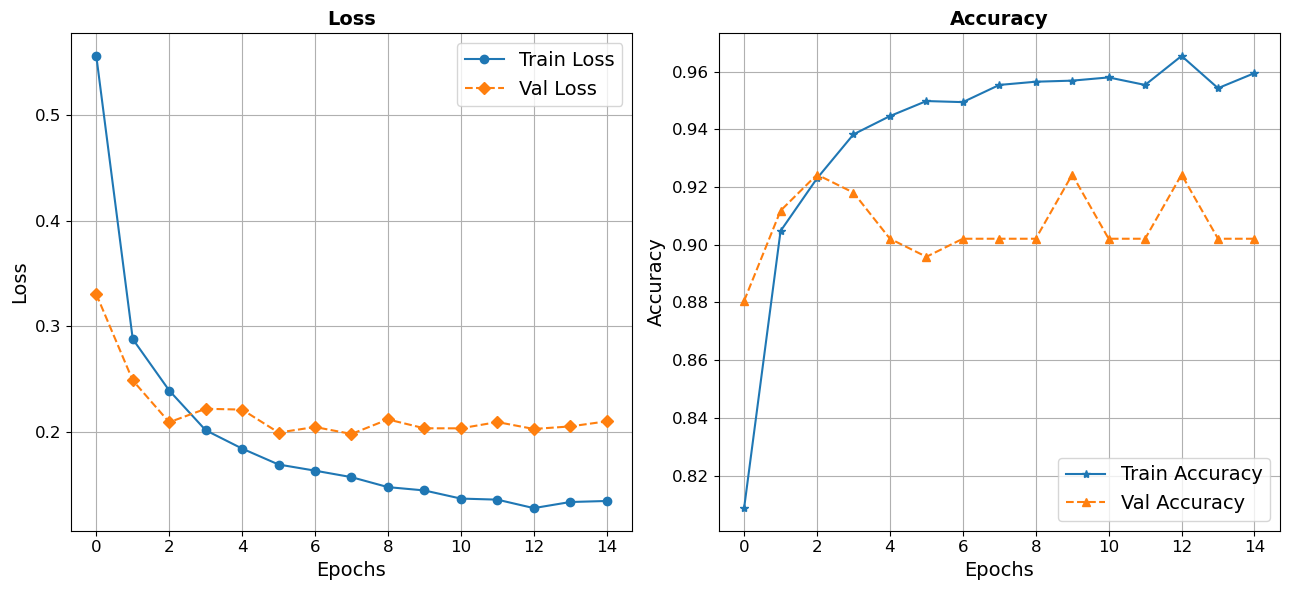

In [23]:
plot_loss_curves(results=results)

### Plotting confusion matrix

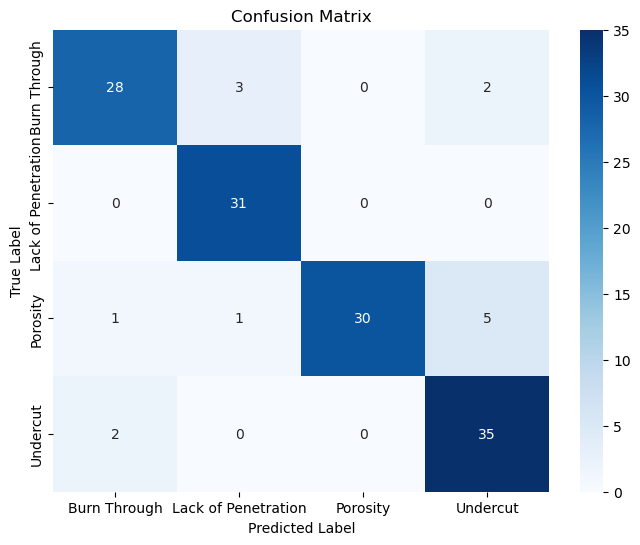

In [24]:
plot_confusion_matrix(model=conv_model,
                     dataloader=test_dataloader,
                     class_names=class_names,
                     device=device)

### 2.2 Fine Tuning

In [25]:
from pathlib import Path
checkpoint_path = Path('C:/Users/Sadat Iqbal/Desktop/Python Works/Torch_CUDA/Publication_Phase_2_models/ConvNeXt_Augmented_data_15_epochs.pth')
checkpoint = torch.load(checkpoint_path,
                       map_location=device)

C:\Users\Sadat Iqbal\AppData\Local\Temp\ipykernel_4536\2877718961.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path,


In [26]:
conv_finetune = torchvision.models.convnext_small(weights=None).to(device)
conv_finetune.classifier = nn.Sequential(
    LayerNorm2d(768, eps=1e-6,affine=True),
    nn.Flatten(start_dim=1),
    nn.Linear(in_features=768, out_features=num_classes)
).to(device)

conv_finetune.load_state_dict(checkpoint['model_state_dict'])

#freezing all feature_extractor layers first
for name, param in conv_finetune.features.named_parameters():
    param.requires_grad = False

for name, param in list(conv_finetune.features.named_parameters())[-15:]:
    param.requires_grad = True

In [27]:
summary(conv_finetune,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [32, 3, 224, 224]    [32, 4]              --                   Partial
├─Sequential (features)                                 [32, 3, 224, 224]    [32, 768, 7, 7]      --                   Partial
│    └─Conv2dNormActivation (0)                         [32, 3, 224, 224]    [32, 96, 56, 56]     --                   False
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 96, 56, 56]     (4,704)              False
│    │    └─LayerNorm2d (1)                             [32, 96, 56, 56]     [32, 96, 56, 56]     (192)                False
│    └─Sequential (1)                                   [32, 96, 56, 56]     [32, 96, 56, 56]     --                   False
│    │    └─CNBlock (0)                                 [32, 96, 56, 56]     [32, 96, 56, 56]     (79,296)           

### Training/Fine-Tuning

In [28]:
#setting up random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#setting up a loss_fn and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, conv_finetune.parameters()),
    lr = 1e-5
)

fine_tune_epochs = 5

#starting the timer
start_time = timer()

finetune_results = train(model=conv_finetune,
                        train_dataloader=train_dataloader_aug,
                        val_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=criterion,
                        epochs=fine_tune_epochs,
                        device=device,
                        writer=create_writer(experiment_name='Augmented_Data',
                                            model_name='ConvNeXt',
                                            extra=f'finetuned_for_{fine_tune_epochs}_epochs')
                        )
end_time = timer()
print(f'Time taken for Fine-Tuning: {end_time-start_time:.3f} seconds')
print('\n')

save_filepath = 'ConvNeXt_Augmented_data_finetuned_for_5_epochs.pth'
save_model(model=conv_finetune,
          optimizer=optimizer,
          epoch=fine_tune_epochs,
          initial_training_completed=True,
          target_dir='Publication_Phase_2_models',
          model_name=save_filepath)

print('Fine-tuned model saved to desired directory!!!'+'\n')
print('-'*50)

Created SummaryWriter saving to Publication_Phase_2_logs\2025-09-03\Augmented_Data\ConvNeXt\finetuned_for_5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1| Train loss: 0.1227 and Train acuuracry: 0.9661 |
                  Validation loss: 0.2056 and Validation accuracy: 0.9021|
                  LR: 1e-05
Epoch: 2| Train loss: 0.1180 and Train acuuracry: 0.9665 |
                  Validation loss: 0.2003 and Validation accuracy: 0.9243|
                  LR: 1e-05
Epoch: 3| Train loss: 0.1173 and Train acuuracry: 0.9643 |
                  Validation loss: 0.1933 and Validation accuracy: 0.9243|
                  LR: 1e-05
Epoch: 4| Train loss: 0.1080 and Train acuuracry: 0.9725 |
                  Validation loss: 0.1988 and Validation accuracy: 0.9243|
                  LR: 1e-05
Epoch: 5| Train loss: 0.1054 and Train acuuracry: 0.9702 |
                  Validation loss: 0.1818 and Validation accuracy: 0.9243|
                  LR: 1e-05
Time taken for Fine-Tuning: 166.654 seconds


[INFO] Saving checkpoint to: Publication_Phase_2_models\ConvNeXt_Augmented_data_finetuned_for_5_epochs.pth
Fine-tuned model saved to desired dir

### Plotting loss curves

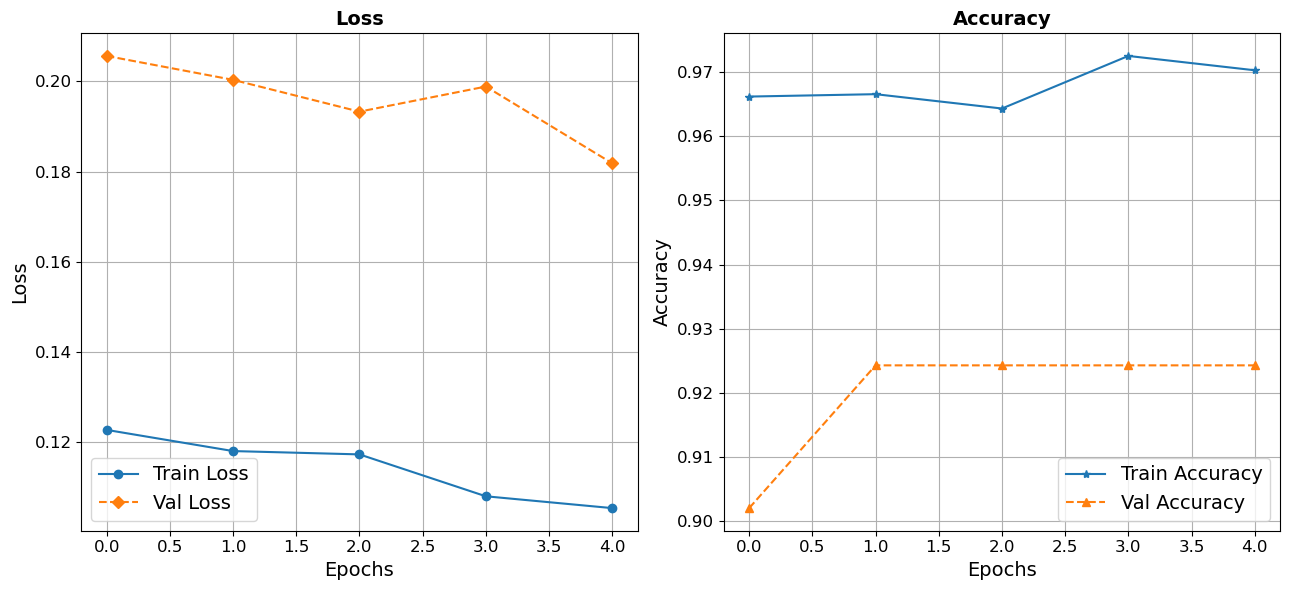

In [29]:
plot_loss_curves(results=finetune_results)

### Ploting Confusion Matrix

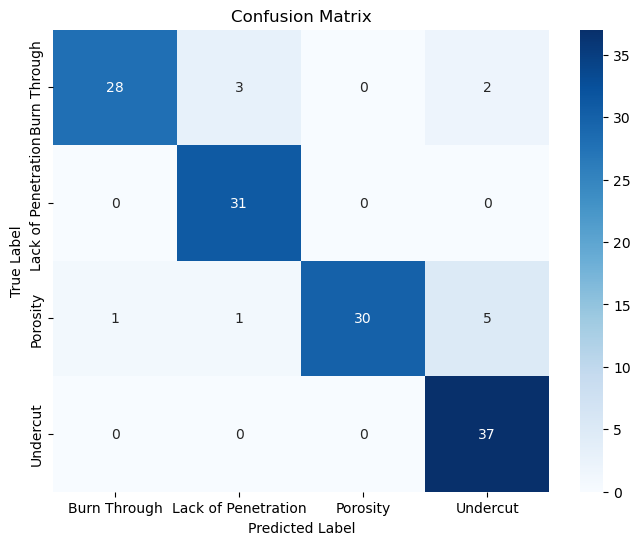

In [30]:
plot_confusion_matrix(model=conv_finetune,
                     dataloader=test_dataloader,
                     class_names=class_names,
                     device=device)

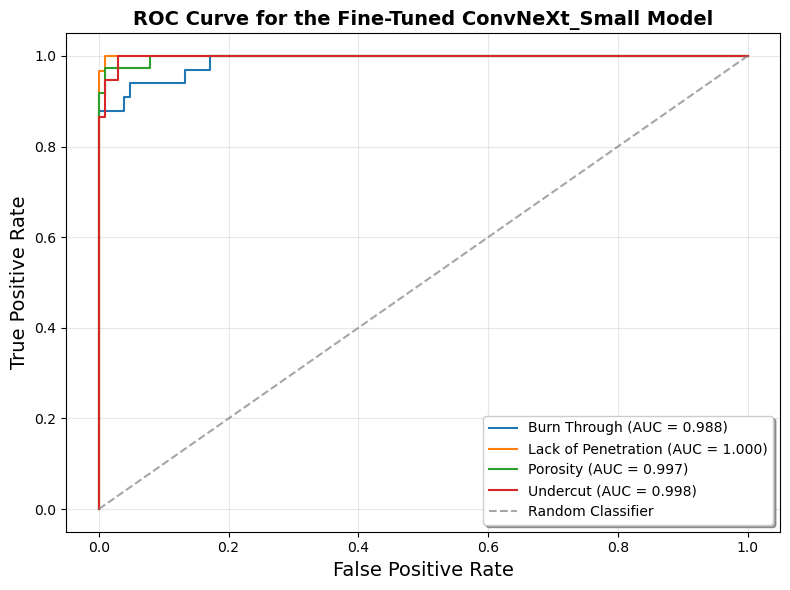

In [31]:
plot_multiclass_roc_curve(model=conv_finetune,
                         dataloader=test_dataloader,
                         class_names=class_names,
                         device=device,
                         title='ROC Curve for the Fine-Tuned ConvNeXt_Small Model')

# 3. Effect of SENet Attention Module

In [32]:
from AttentionModules.SENet import SEModule

In [33]:
class convnext_with_senet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()

        self.weights = torchvision.models.ConvNeXt_Small_Weights.DEFAULT
        self.model = torchvision.models.convnext_small(weights=self.weights)
        self.feature_extractor = self.model.features
        self.senet = SEModule(channels=768)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            LayerNorm2d(768, eps=1e-6,affine=True),
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=768, out_features=num_classes)
        )

    def forward(self,x):
        x = self.feature_extractor(x)
        x = self.senet(x)
        x = self.pool(x)
        x = self.classifier(x)

        return x

In [34]:
conv_se = convnext_with_senet(num_classes=num_classes).to(device)

summary(conv_se,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
convnext_with_senet (convnext_with_senet)               [32, 3, 224, 224]    [32, 4]              770,536              True
├─Sequential (feature_extractor)                        [32, 3, 224, 224]    [32, 768, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                         [32, 3, 224, 224]    [32, 96, 56, 56]     --                   True
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 96, 56, 56]     4,704                True
│    │    └─LayerNorm2d (1)                             [32, 96, 56, 56]     [32, 96, 56, 56]     192                  True
│    └─Sequential (1)                                   [32, 96, 56, 56]     [32, 96, 56, 56]     --                   True
│    │    └─CNBlock (0)                                 [32, 96, 56, 56]     [32, 96, 56, 56]     79,296               True
│  

In [35]:
for param in conv_se.feature_extractor.parameters():
    param.requires_grad = False

summary(conv_se,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
convnext_with_senet (convnext_with_senet)               [32, 3, 224, 224]    [32, 4]              770,536              Partial
├─Sequential (feature_extractor)                        [32, 3, 224, 224]    [32, 768, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                         [32, 3, 224, 224]    [32, 96, 56, 56]     --                   False
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 96, 56, 56]     (4,704)              False
│    │    └─LayerNorm2d (1)                             [32, 96, 56, 56]     [32, 96, 56, 56]     (192)                False
│    └─Sequential (1)                                   [32, 96, 56, 56]     [32, 96, 56, 56]     --                   False
│    │    └─CNBlock (0)                                 [32, 96, 56, 56]     [32, 96, 56, 56]     (79,296)             

### Training

In [36]:
#setting up random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#setting up a loss_fn, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(conv_se.parameters(), lr = 1e-3)

#a lr_schedular
def lr_lambda(epoch):
    if epoch<5:
        return 1
    elif epoch<10:
        return 0.5
    else:
        return 0.1

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,
                                             lr_lambda=lr_lambda)

#number of training epochs
n_epochs = 15

#starting the timer
start_time = timer()

results_se = train(model=conv_se,
                  train_dataloader=train_dataloader_aug,
                  val_dataloader=val_dataloader,
                  optimizer=optimizer,
                  loss_fn=criterion,
                  lr_scheduler=scheduler,
                  epochs=n_epochs,
                  device=device,
                  writer=create_writer(experiment_name='Augmented_Data',
                                      model_name='ConvNeXt',
                                      extra=f'{n_epochs}_epochs')
                  )
end_time = timer()
print(f'Total training time with SENet: {end_time-start_time:.3f} seconds')

save_filepath = 'ConvNeXT_with_SENet_Augmented_data_15_epochs.pth'
save_model(model=conv_se,
          optimizer=optimizer,
          scheduler=scheduler,
          epoch=n_epochs,
          initial_training_completed=False,
          target_dir='Publication_Phase_2_models',
          model_name=save_filepath)

print('model saved to desired directory!!!'+'\n')
print('-'*50)

Created SummaryWriter saving to Publication_Phase_2_logs\2025-09-03\Augmented_Data\ConvNeXt\15_epochs


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1| Train loss: 0.5086 and Train acuuracry: 0.8207 |
                  Validation loss: 0.2876 and Validation accuracy: 0.8931|
                  LR: 0.001
Epoch: 2| Train loss: 0.2403 and Train acuuracry: 0.9185 |
                  Validation loss: 0.2099 and Validation accuracy: 0.9118|
                  LR: 0.001
Epoch: 3| Train loss: 0.1910 and Train acuuracry: 0.9327 |
                  Validation loss: 0.1833 and Validation accuracy: 0.9181|
                  LR: 0.001
Epoch: 4| Train loss: 0.1583 and Train acuuracry: 0.9487 |
                  Validation loss: 0.1994 and Validation accuracy: 0.9181|
                  LR: 0.001
Epoch: 5| Train loss: 0.1379 and Train acuuracry: 0.9554 |
                  Validation loss: 0.1926 and Validation accuracy: 0.9021|
                  LR: 0.001
Epoch: 6| Train loss: 0.1139 and Train acuuracry: 0.9665 |
                  Validation loss: 0.1642 and Validation accuracy: 0.9306|
                  LR: 0.0005
Epoch: 7| Train loss: 0.110

### Plotting Loss Curves

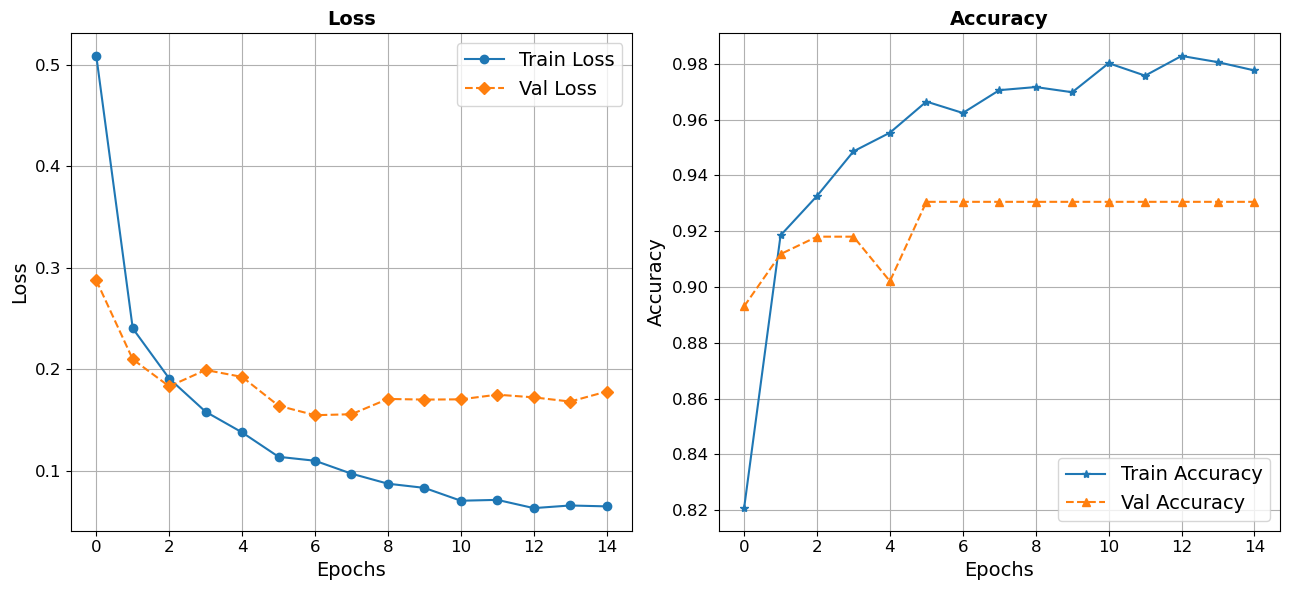

In [37]:
plot_loss_curves(results=results_se)

### Plotting Confusion Matrix

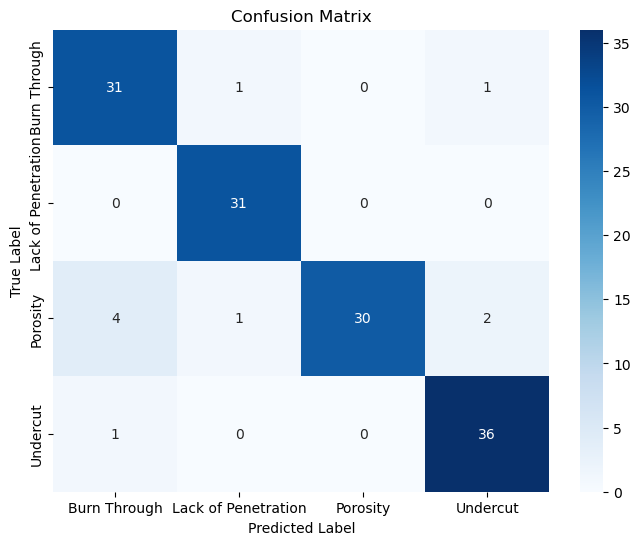

In [38]:
plot_confusion_matrix(model=conv_se,
                     dataloader=test_dataloader,
                     class_names=class_names,
                     device=device)

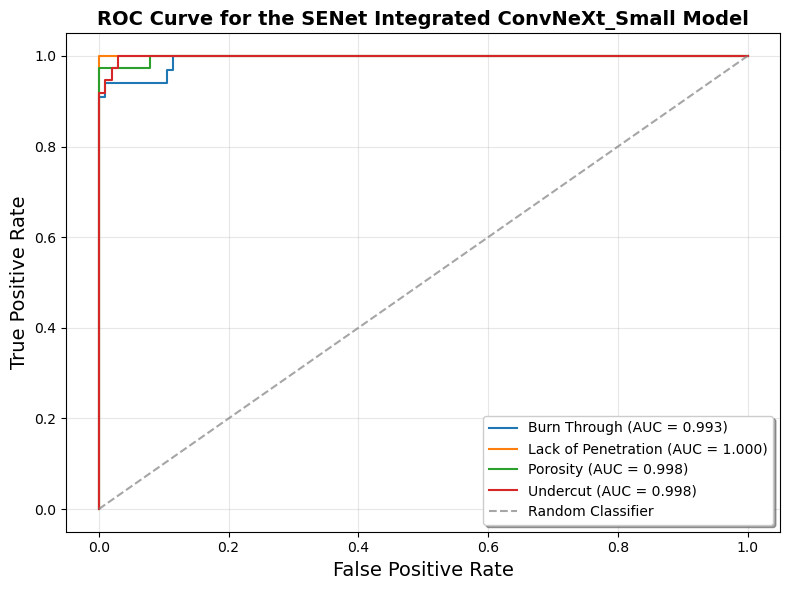

In [39]:
plot_multiclass_roc_curve(model= conv_se,
                         dataloader=test_dataloader,
                         class_names=class_names,
                         device=device,
                         title = 'ROC Curve for the SENet Integrated ConvNeXt_Small Model')